In [23]:
from pathlib import Path

import torch
import torchvision
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.image_generation.models.gan import GANDiscriminator, GANGenerator
from torchvision import transforms
from tqdm import tqdm

# Setting

In [24]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [25]:
artifact_path = Path("../../artifacts/gan")
data_path = Path("../../data/fashionMnist")

In [26]:
DEVICE = torch.device("cuda:0")

# Data

In [27]:
preprocess = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

In [28]:
train_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

In [29]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

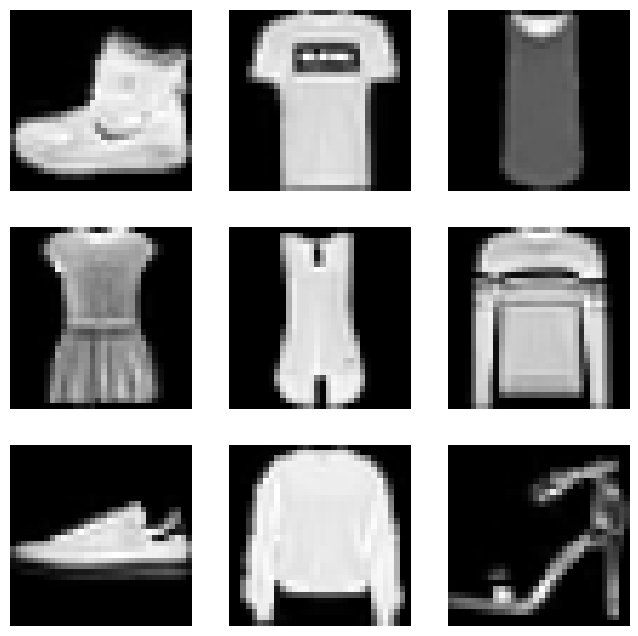

In [30]:
# 資料集繪圖
plot_grids(
    [*img_tensor_to_np(torch.stack([train_data[i][0] for i in range(9)]))],
    num_row=3,
    num_col=3,
    cmap="gray",
)

# model

In [31]:
LATENT_DIM = 128
HIDDEN_DIM = 256

In [32]:
generator = GANGenerator(
    LATENT_DIM,
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
).to(DEVICE)
discriminator = GANDiscriminator(
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
    dropout_prob=0,
).to(DEVICE)

In [33]:
torchinfo.summary(generator)

Layer (type:depth-idx)                   Param #
GANGenerator                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       33,024
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       131,584
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       525,312
│    └─LeakyReLU: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       1,049,600
│    └─Tanh: 2-8                         --
Total params: 1,739,520
Trainable params: 1,739,520
Non-trainable params: 0

In [34]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
GANDiscriminator                         --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       524,800
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       131,328
│    └─LeakyReLU: 2-4                    --
├─Sequential: 1-3                        --
│    └─Dropout: 2-5                      --
│    └─Linear: 2-6                       257
Total params: 656,385
Trainable params: 656,385
Non-trainable params: 0

# train

In [35]:
LR = 1e-4
BETA = (0.5, 0.999)

In [36]:
criterion = nn.BCEWithLogitsLoss(reduction="mean")
optim_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [37]:
EPOCH = 20

In [38]:
N = len(train_data)
valid = torch.ones(BATCH_SIZE, 1).to(DEVICE)
fake = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
for e in range(EPOCH):
    running_loss_G = 0.0
    running_loss_D = 0.0

    for img, _ in tqdm(train_loader):
        img = img.to(DEVICE)

        discriminator.train()
        generator.eval()
        optim_D.zero_grad()
        optim_G.zero_grad()
        noise = generate_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        real_loss = criterion(discriminator(img), valid)
        fake_loss = criterion(discriminator(gen_img.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optim_D.step()
        running_loss_D += d_loss.item()

        generator.train()
        discriminator.eval()
        optim_D.zero_grad()
        optim_G.zero_grad()
        noise = generate_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        g_loss = criterion(discriminator(gen_img), valid)
        g_loss.backward()
        optim_G.step()
        running_loss_G += g_loss.item()

    print(
        f"epoch {e+1}: D: {running_loss_D / N} G: {running_loss_G / N}"
    )

100%|██████████| 468/468 [00:19<00:00, 24.19it/s]


epoch 1: D: 0.004774274805188179 G: 0.0066507078136006995


100%|██████████| 468/468 [00:19<00:00, 24.33it/s]


epoch 2: D: 0.004652475031713644 G: 0.007874268567562103


100%|██████████| 468/468 [00:21<00:00, 21.65it/s]


epoch 3: D: 0.004672614992161592 G: 0.0086614972392718


100%|██████████| 468/468 [00:22<00:00, 21.24it/s]


epoch 4: D: 0.004589657524724801 G: 0.008778885392347972


100%|██████████| 468/468 [00:21<00:00, 21.29it/s]


epoch 5: D: 0.004508637702961763 G: 0.009238215940197308


100%|██████████| 468/468 [00:18<00:00, 24.70it/s]


epoch 6: D: 0.004589661874373754 G: 0.009362971552213033


100%|██████████| 468/468 [00:18<00:00, 24.73it/s]


epoch 7: D: 0.004518462898333867 G: 0.009547066842516263


100%|██████████| 468/468 [00:18<00:00, 25.38it/s]


epoch 8: D: 0.0047370244105656946 G: 0.008768693842490514


100%|██████████| 468/468 [00:21<00:00, 21.63it/s]


epoch 9: D: 0.00480473825931549 G: 0.008247288279732068


100%|██████████| 468/468 [00:22<00:00, 21.03it/s]


epoch 10: D: 0.004862300993998845 G: 0.007938933345675468


100%|██████████| 468/468 [00:19<00:00, 23.81it/s]


epoch 11: D: 0.004916310761372248 G: 0.007945226381222407


100%|██████████| 468/468 [00:18<00:00, 25.67it/s]


epoch 12: D: 0.004916709738969803 G: 0.007752279468377431


100%|██████████| 468/468 [00:18<00:00, 25.85it/s]


epoch 13: D: 0.004879499792059263 G: 0.008149609823028247


100%|██████████| 468/468 [00:18<00:00, 25.78it/s]


epoch 14: D: 0.004963909140229225 G: 0.007776342995961507


100%|██████████| 468/468 [00:21<00:00, 22.03it/s]


epoch 15: D: 0.005100526982545853 G: 0.0074863676657279336


100%|██████████| 468/468 [00:22<00:00, 20.60it/s]


epoch 16: D: 0.005088555909196536 G: 0.007074933415651322


100%|██████████| 468/468 [00:17<00:00, 26.13it/s]


epoch 17: D: 0.0050963037878274916 G: 0.007161622064312299


100%|██████████| 468/468 [00:21<00:00, 21.67it/s]


epoch 18: D: 0.005103391528129578 G: 0.007154350334405899


100%|██████████| 468/468 [00:21<00:00, 21.52it/s]


epoch 19: D: 0.005114297485351562 G: 0.007033053844173749


100%|██████████| 468/468 [00:21<00:00, 21.51it/s]


epoch 20: D: 0.005097343004743259 G: 0.007088982194662094


100%|██████████| 468/468 [00:21<00:00, 21.82it/s]


epoch 21: D: 0.005064014739791552 G: 0.007071500406662623


100%|██████████| 468/468 [00:21<00:00, 21.41it/s]


epoch 22: D: 0.005056069067120552 G: 0.007131486546993256


100%|██████████| 468/468 [00:18<00:00, 24.98it/s]


epoch 23: D: 0.005025999194383621 G: 0.0070776143014431


100%|██████████| 468/468 [00:20<00:00, 22.52it/s]


epoch 24: D: 0.005045747652649879 G: 0.007113728192448616


100%|██████████| 468/468 [00:18<00:00, 25.06it/s]


epoch 25: D: 0.005034001745780309 G: 0.007106048889954885


100%|██████████| 468/468 [00:19<00:00, 24.14it/s]


epoch 26: D: 0.005013399500648181 G: 0.007118292426069577


100%|██████████| 468/468 [00:19<00:00, 24.05it/s]


epoch 27: D: 0.005004836566249529 G: 0.007083325717846553


100%|██████████| 468/468 [00:19<00:00, 24.01it/s]


epoch 28: D: 0.004997964731852214 G: 0.007092852593461672


100%|██████████| 468/468 [00:19<00:00, 23.84it/s]


epoch 29: D: 0.004988021250565847 G: 0.0071224929024775825


100%|██████████| 468/468 [00:19<00:00, 24.07it/s]

epoch 30: D: 0.00496352097094059 G: 0.007052154976129532


# evaluation

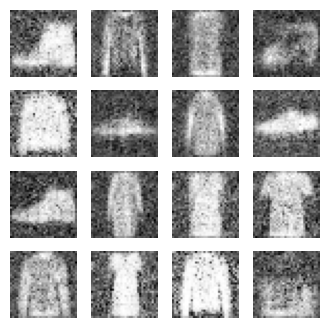

In [46]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_normal(16, LATENT_DIM).to(DEVICE)
    gen_img = generator(noise)
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=4,
        num_col=4,
        is_gray_scale=True,
        figsize=(4,4),
    )

In [40]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(train_loader):
        img = img.to(DEVICE)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 468/468 [00:11<00:00, 40.56it/s]

0.5272


In [41]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, label in tqdm(train_loader):
        noise = generate_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 468/468 [00:11<00:00, 39.61it/s]

0.2678833333333333


In [42]:
model_path = artifact_path / 'gan.pth'

In [43]:
torch.save(generator.state_dict(), model_path.as_posix())

In [44]:
generator.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>